In [ ]:
import os
import shutil
import os
 
# get current directory
cwd = os.getcwd()
parent = os.path.dirname(cwd)
parent = os.path.dirname(parent)

src_folder = parent + '\\Generation\\runs\\' 
dst_folder = './src/'
print(src_folder)
print(dst_folder)

# Copy all files from src_folder to dst_folder
for file_name in os.listdir(src_folder):
    shutil.copy(src_folder + file_name, dst_folder)

In [ ]:
exp_name = 'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java'
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
!python convert_to_pre_eval.py --source_file $sf --target_dir $td


In [ ]:
# import subprocess
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"


# # subprocess.run(eval_cmd, shell=True)
print("### EVALUATION COMMAND ###")
print('#',eval_cmd)
print("### EVALUATION COMMAND ###")


In [ ]:
### EVALUATION COMMAND ###
# podman run --rm --network none -v ./tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java:/tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java:rw multipl-e-eval --dir /tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java --output-dir /tgt/codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java --recursive
### EVALUATION COMMAND ###

In [ ]:
# exp_name = 'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_800_humaneval_java'
sf = f'src/{exp_name}.jsonl'
td = f'tgt/{exp_name.replace("-", "")}'
target_dir = f'{td}'
output_file = f'res/{exp_name}_results.json'
!python pass_k.py $target_dir --output $output_file

#### Visualize the results

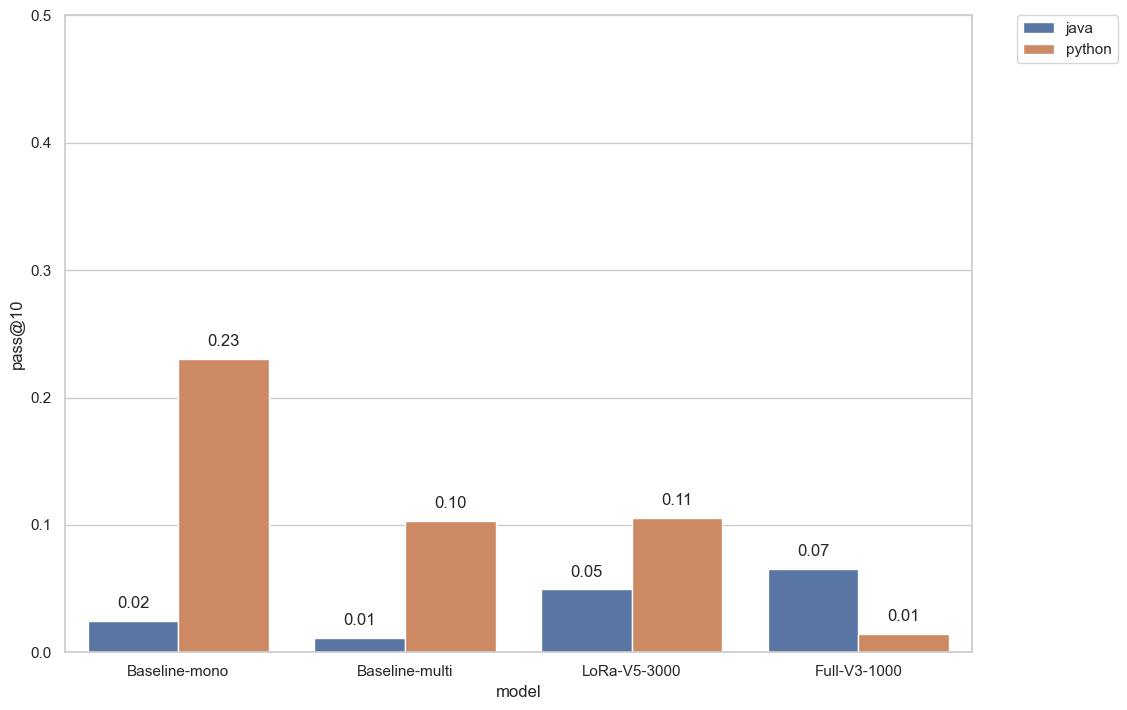

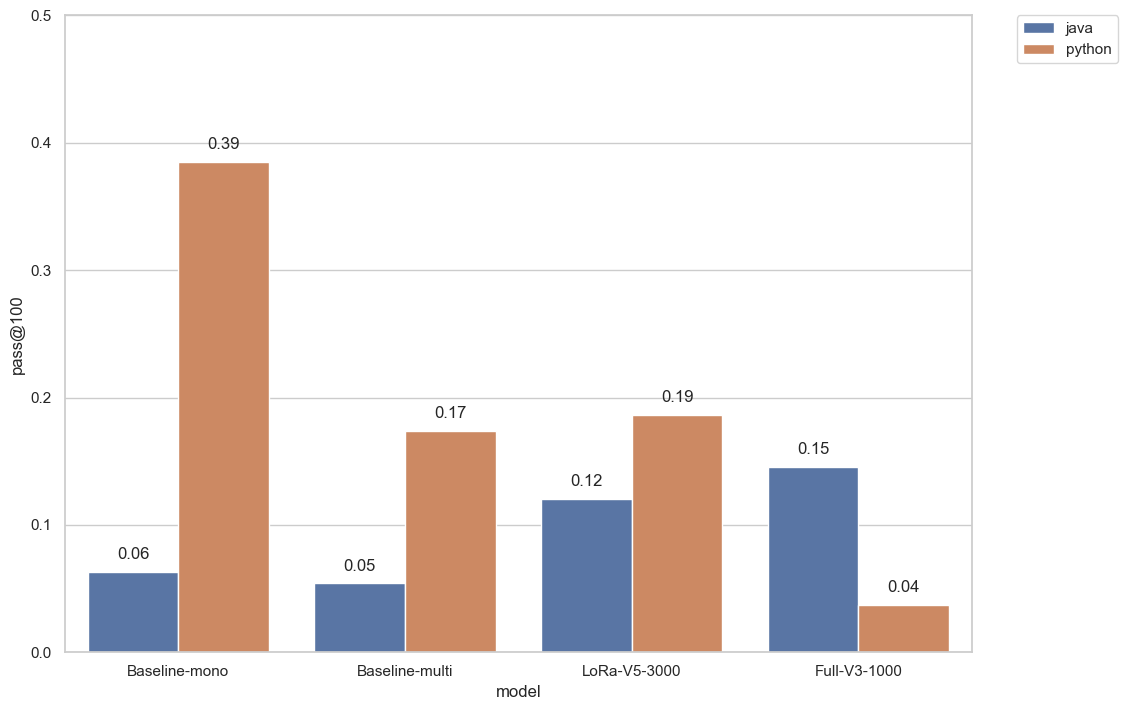

In [24]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})


#get all the results files in the res folder
results_files = [f for f in os.listdir('res') if os.path.isfile(os.path.join('res', f))]

#load all the results files into a dictionary
results = {}
for f in results_files:
    with open(os.path.join('res', f)) as json_file:
        results[f] = json.load(json_file)
['Baseline', 'LoRa-V3-2000',
       'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java',
       'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py',
       'Full-V3-1000']
#Models Short Names
model_names_dict = {
    'codegen_350M_mono_humaneval_py': 'Baseline-mono',
    'codegen_350M_mono_humaneval_java': 'Baseline-mono',

    'codegen_350M_multi_humaneval_py': 'Baseline-multi',
    'codegen_350M_multi_humaneval_java': 'Baseline-multi',

    'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_py': 'LoRa-V3-2000',
    'codegne_finetuned_LoRa_the_stack_java_v3_checkpoint_2000_humaneval_java': 'LoRa-V3-2000',

    'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_java': 'LoRa-V5-1000',
    'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_1000_humaneval_py': 'LoRa-V5-1000',

    'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_3000_humaneval_java': 'LoRa-V5-3000',
    'codegne_finetuned_LoRa_the_stack_java_v5_checkpoint_3000_humaneval_py': 'LoRa-V5-3000',

    'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_py': 'Full-V3-1000',
    'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java': 'Full-V3-1000'
}


#Merge all the results into a single dataframe
dict_df = {
    'model': [],
    'dataset': [],
    'pass@10': [],
    'pass@100': [],
    'num_problems': [],
    'min_completions': [],
    'max_completions': [],
    'programming_language': []
}

for model in results.keys():
    model_results = results[model]
    model_name = model.split('_results.json')[0]
    if model_name in model_names_dict.keys():
        model_name = model_names_dict[model_name]
    dataset_name = model_results['pass@10']['dataset']
    pass_10 = model_results['pass@10']['estimate']
    pass_100 = model_results['pass@100']['estimate']
    num_problems = model_results['pass@10']['num_problems']
    min_completions = model_results['pass@10']['min_completions']
    max_completions = model_results['pass@10']['max_completions']
    if 'humaneval_py' in dataset_name:
        programming_language = 'python'
    elif 'humaneval_java' in dataset_name:
        programming_language = 'java'
    else:
        programming_language = 'unknown'
    dict_df['model'].append(model_name)
    dict_df['dataset'].append(dataset_name)
    dict_df['pass@10'].append(pass_10)
    dict_df['pass@100'].append(pass_100)
    dict_df['num_problems'].append(num_problems)
    dict_df['min_completions'].append(min_completions)
    dict_df['max_completions'].append(max_completions)
    dict_df['programming_language'].append(programming_language)

df = pd.DataFrame(dict_df)

#Drop the dataset column
df = df.drop(columns=['dataset'])

#Drop the min_completions and max_completions columns
df = df.drop(columns=['min_completions', 'max_completions'])

#Drop the num_problems column
# df = df.drop(columns=['num_problems'])

#Drop the LoRa-V3-2000 model
df = df[df['model'] != 'LoRa-V3-2000']

#Drop the LoRa-V5-1000 model
df = df[df['model'] != 'LoRa-V5-1000']

#Plot the results
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="model", y="pass@10", hue="programming_language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 0.5
plt.ylim(0, 0.5)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#plot the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

#Plot the results
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="model", y="pass@100", hue="programming_language", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
#set the y axis to start at 0 and end at 0.5
plt.ylim(0, 0.5)
#writer the y values on top of the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#plot the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()



In [25]:
df

,model,pass@10,pass@100,num_problems,programming_language
0,Baseline-mono,0.024779,0.063291,158,java
1,Baseline-mono,0.230278,0.385093,161,python
2,Baseline-multi,0.011250,0.054054,37,java
3,Baseline-multi,0.103036,0.173913,161,python
8,LoRa-V5-3000,0.049458,0.120253,158,java
9,LoRa-V5-3000,0.105701,0.186335,161,python
10,Full-V3-1000,0.065599,0.145570,158,java
11,Full-V3-1000,0.014519,0.037267,161,python


### ALL FLOW

In [ ]:
import os
import shutil
import subprocess

 
# get current directory
cwd = os.getcwd()
parent = os.path.dirname(cwd)
parent = os.path.dirname(parent)

src_folder = parent + '\\Generation\\runs\\' 
dst_folder = './src/'

# Copy all files from src_folder to dst_folder
for file_name in os.listdir(src_folder):
    shutil.copy(src_folder + file_name, dst_folder)


#Loop over all the files in the src folder and get the experiment names to run
for file_name in os.listdir(src_folder):
    exp_name = file_name.split('.jsonl')[0]
    #Print the experiment name
    print(f'Now running experiment: {exp_name}')

    #Convert the jsonl file to the pre-evaluation format
    sf = f'src/{exp_name}.jsonl'
    td = f'tgt/{exp_name.replace("-", "")}'
    print(f'Converting {sf} to {td}')
    !python convert_to_pre_eval.py --source_file $sf --target_dir $td
    print('Done!')

    #Run the evaluation
    print(f'Running evaluation on {td}')
    eval_cmd = f"podman run --rm --network none -v ./{td}:/{td}:rw multipl-e-eval --dir /{td} --output-dir /{td} --recursive"
    # subprocess.run(eval_cmd, shell=True)
    print("### EVALUATION COMMAND ###")
    print('#',eval_cmd)
    print("### EVALUATION COMMAND ###")
    # print('Done!')

    # Run the pass@k
    print(f'Running pass@k on {td}')
    target_dir = f'{td}'
    output_file = f'res/{exp_name}_results.json'
    !python pass_k.py $target_dir --output $output_file
    print('Done!')

    

# Error Analysis

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})



# Function to get all the statuses from a list of results
def get_all_statuses(results):
    all_statuses = []
    for result in results:
        all_statuses.append(result['status'])
    return all_statuses

# Function to get all statuses for all the results files in a tgt folder
def get_all_statuses_for_tgt_folder(tgt_folder):
    results_files = [f for f in os.listdir(tgt_folder) if os.path.isfile(os.path.join(tgt_folder, f)) and f.endswith('.results.json')]
    print(f'We have {len(results_files)} results files')
    all_statuses = {
        'results_file': [],
        'status': []
    }
    for results_file in results_files:
        with open(os.path.join(tgt_folder, results_file)) as json_file:
            data = json.load(json_file)
        results = data['results']
        statuses = get_all_statuses(results)
        all_statuses['results_file'].extend([results_file] * len(statuses))
        all_statuses['status'].extend(statuses)
    return all_statuses


#Function to plot the statuses for a tgt folder
def plot_statuses_for_tgt_folder(tgt_folder):
    all_statuses = get_all_statuses_for_tgt_folder(tgt_folder)
    df = pd.DataFrame(all_statuses)
    ax = sns.countplot(x="status", data=df)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 0.01,
                '{:1.2f}'.format(height),
                ha="center")
    plt.show()

#Function to put all the resluts from all folders into a single dataframe
def get_all_results_for_tgt_folder():
    root_folder = 'tgt'
    tgt_folders = [f for f in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, f))]
    print(f'We have {len(tgt_folders)} tgt folders')
    root_df = {
        'results_folder': [],
        'results_file': [],
        'status': [],
    }
    for tgt_folder in tgt_folders:
        all_statuses = get_all_statuses_for_tgt_folder(os.path.join(root_folder, tgt_folder))
        root_df['results_file'].extend(all_statuses['results_file'])
        root_df['status'].extend(all_statuses['status'])
        root_df['results_folder'].extend([tgt_folder] * len(all_statuses['status']))
    return pd.DataFrame(root_df)




In [ ]:
df = get_all_results_for_tgt_folder()

In [ ]:
df.results_folder.unique()

In [ ]:
# Drop results folders that we don't want to plot, we only want to plot these:
#[
#    'codegen_350M_mono_humaneval_py',
#    'codegen_350M_mono_humaneval_java',
#    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java',
#    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py',
# 'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py'
# 'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java'
# ]

df = df[df.results_folder.isin([
    'codegen_350M_mono_humaneval_py',
    'codegen_350M_mono_humaneval_java',
    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_java',
    'codegne_finetuned_LoRa_the_stack_java_v2_checkpoint_800_humaneval_py',
    'codegne_finetuned_the_stack_java_v2_checkpoint_200_humaneval_py',
    'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java'
])]

In [ ]:
# add language column to the dataframe, 
# if results_folder end with _py then language is python
# if results_folder end with _java then language is java
# else language is unknown

df['language'] = np.where(df['results_folder'].str.endswith('_py'), 'python', np.where(df['results_folder'].str.endswith('_java'), 'java', 'unknown'))

df_java = df[df.language == 'java']
df_python = df[df.language == 'python']

In [ ]:
df.results_folder.value_counts()

In [ ]:


#Plot the statuses counts grouped by results folder
ax = sns.countplot(x="status", hue="results_folder", data=df_java)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
plt.show()




#Plot the statuses counts grouped by results folder
ax = sns.countplot(x="status", hue="results_folder", data=df_python)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 0.01,
            '{:1.2f}'.format(height),
            ha="center")
#plot the legend outside the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [ ]:
df.results_folder.unique()

In [ ]:
#get all the folders in the tgt folder
tgt_folders = [f for f in os.listdir('tgt') if os.path.isdir(os.path.join('tgt', f))]
print(f'We have {len(tgt_folders)} tgt folders')
for tgt_folder in tgt_folders:
    print(tgt_folder)

In [ ]:
folder1 = 'codegen_350M_mono_humaneval_py'
folder2 = 'codegne_finetuned_the_stack_java_v3_checkpoint_1000_humaneval_java'
folder1 = 'tgt' + '/' + folder1
folder2 = 'tgt' + '/' + folder2
plot_statuses_for_two_tgt_folders(folder1, folder2)